In [1]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.6 MB/s eta 0:00:00


In [2]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf

In [3]:
!pip install gdown

In [4]:
import gdown

file_url = 'https://drive.google.com/uc?id=1xJrBkcyBb6dMaqgmVYdg4pH-INvhUk6V'
output_path = '/content/transaction-yes-no.zip'

# Download the file
gdown.download(file_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1xJrBkcyBb6dMaqgmVYdg4pH-INvhUk6V
From (redirected): https://drive.google.com/uc?id=1xJrBkcyBb6dMaqgmVYdg4pH-INvhUk6V&confirm=t&uuid=63e885c9-e583-4aeb-9550-72ada6b38411
To: /content/transaction-yes-no.zip
100%|██████████| 519M/519M [00:11<00:00, 46.0MB/s]


'/content/transaction-yes-no.zip'

In [5]:
!unzip /content/transaction-yes-no.zip -d /content/

Archive:  /content/transaction-yes-no.zip
   creating: /content/transaction-yes-no/
   creating: /content/transaction-yes-no/No/
  inflating: /content/transaction-yes-no/No/00083029106fd01e17ac7bff434b2e2d.jpg  
  inflating: /content/transaction-yes-no/No/0052aa16ede0838efb5f97670940d9d1.jpg  
  inflating: /content/transaction-yes-no/No/005fe1fa75dac6dafd2aca9ab018667b.jpg  
  inflating: /content/transaction-yes-no/No/0076bc0e4d33dae47ae010ac62cbe428.jpg  
  inflating: /content/transaction-yes-no/No/009158adc4f190cd0079d9dd2b1d22ea.jpg  
  inflating: /content/transaction-yes-no/No/009429555a31bf30755c1eca46ebb814.jpg  
  inflating: /content/transaction-yes-no/No/00bacc18c92bc1c416c5fb494b82376f.jpg  
  inflating: /content/transaction-yes-no/No/00de2c15d89ca2b5ad4076794f1d1e1a.jpg  
  inflating: /content/transaction-yes-no/No/00f27681fffb05d4ae212ebab257a672.jpg  
  inflating: /content/transaction-yes-no/No/00f995c94db04fa2a6b585af9ad054d6.jpg  
  inflating: /content/transaction-yes-no/

In [6]:
classes = ['No','Yes']

In [13]:
import os
import shutil
import random

def split_images(source_folder, destination_folder, training=0.6, validation=0.3, testing=0.1):
    """
    Distributes image data from 'yes' and 'no' folders into train, val, and test sets.
    Condensed version for brevity.

    Args:
        source_folder (str): Path to the 'yes' and 'no' image folders.
        destination_folder (str): Path to create train/val/test split directories.
        training_proportion (float): Proportion for training set (default: 0.6).
        validation_proportion (float): Proportion for validation set (default: 0.3).
        testing_proportion (float): Proportion for testing set (default: 0.1).
    """

    categories = ['Yes', 'No']
    sets = ['train', 'val', 'test']
    proportions = [training, validation, testing]

    for category in categories:
        category_source = os.path.join(source_folder, category)
        image_files = [f for f in os.listdir(category_source) if os.path.isfile(os.path.join(category_source, f))]
        random.shuffle(image_files)
        num_images = len(image_files)
        split_indices = [int(prop * num_images) for prop in proportions[:-1]] # Calculate split points

        image_sets = [image_files[:split_indices[0]],  # Train set
                      image_files[split_indices[0]:sum(split_indices)], # Val set
                      image_files[sum(split_indices):]] # Test set

        for set_name, image_list in zip(sets, image_sets):
            output_dir = os.path.join(destination_folder, set_name, category)
            os.makedirs(output_dir, exist_ok=True)
            for img in image_list:
                shutil.copy2(os.path.join(category_source, img), os.path.join(output_dir, img))

        print(f"Category '{category}':")
        for i, set_name in enumerate(sets):
            print(f"  {set_name.capitalize()} set: {len(image_sets[i])} images")
        print("-" * 30)

    print(f"Dataset split into train, validation, and test sets in '{destination_folder}'")

In [17]:
input_dir = 'transaction-yes-no/'
output_dir = 'split_dataset/'

split_images(input_dir, output_dir)

Category 'Yes':
  Train set: 842 images
  Val set: 421 images
  Test set: 141 images
------------------------------
Category 'No':
  Train set: 2128 images
  Val set: 1064 images
  Test set: 355 images
------------------------------
Dataset split into train, validation, and test sets in 'split_dataset/'


In [21]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

def train_efficientnet_from_folders(output_dir, img_height=224, img_width=224, batch_size=32, epochs=20):
    """
    Trains an EfficientNetB0 model on image data split into train, validation, and test folders.

    Assumes the data is already split into 'train', 'val', and 'test' subfolders within `output_dir`,
    and each of these contains 'yes' and 'no' subfolders with images.

    Args:
        output_dir (str): Path to the directory containing 'train', 'val', 'test' folders.
        img_height (int): Height of the input images (default: 224, EfficientNetB0 default).
        img_width (int): Width of the input images (default: 224, EfficientNetB0 default).
        batch_size (int): Batch size for data generators (default: 32).
        epochs (int): Number of training epochs (default: 20).
    """

    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary' # or 'categorical' if you have more classes
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_filepath = os.path.join(output_dir, 'best_model.h5')
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )

    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',
        patience=10, # Stop if val_accuracy doesn't improve for 5 epochs
        restore_best_weights=True,
        mode='max'
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

    loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    print(f"Training completed. Best model saved to '{checkpoint_filepath}'")

    return history, model

Found 2968 images belonging to 2 classes.
Found 1484 images belonging to 2 classes.
Found 496 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/92 ━━━━━━━━━━━━━━━━━━━━ 5s 655ms/step - accuracy: 0.7789 - loss: 0.4717

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7815 - loss: 0.4659

92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 767ms/step - accuracy: 0.7818 - loss: 0.4652 - val_accuracy: 0.8179 - val_loss: 0.3439
Epoch 2/20
 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - accuracy: 0.8750 - loss: 0.3013

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8750 - loss: 0.3013 - val_accuracy: 0.8186 - val_loss: 0.3415
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8488 - loss: 0.3274

92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 664ms/step - accuracy: 0.8489 - loss: 0.3274 - val_accuracy: 0.8363 - val_loss: 0.3002
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8750 - loss: 0.2691 - val_accuracy: 0.8342 - val_loss: 0.3110
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8537 - loss: 0.3135

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 777ms/step - accuracy: 0.8538 - loss: 0.3133 - val_accuracy: 0.8641 - val_loss: 0.2681
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.8750 - loss: 0.3161 - val_accuracy: 0.8587 - val_loss: 0.2740
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8791 - loss: 0.2761

92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 673ms/step - accuracy: 0.8791 - loss: 0.2761 - val_accuracy: 0.8668 - val_loss: 0.2656
Epoch 8/20
 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.8750 - loss: 0.3200

92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.8750 - loss: 0.3200 - val_accuracy: 0.8879 - val_loss: 0.2502
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 652ms/step - accuracy: 0.8686 - loss: 0.2900 - val_accuracy: 0.8723 - val_loss: 0.2602
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 1.0000 - loss: 0.1981 - val_accuracy: 0.8716 - val_loss: 0.2589
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8930 - loss: 0.2562

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 896ms/step - accuracy: 0.8929 - loss: 0.2563 - val_accuracy: 0.8947 - val_loss: 0.2287
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8125 - loss: 0.2765 - val_accuracy: 0.8940 - val_loss: 0.2283
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 891ms/step - accuracy: 0.8926 - loss: 0.2574 - val_accuracy: 0.8913 - val_loss: 0.2420
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9062 - loss: 0.2734 - val_accuracy: 0.8886 - val_loss: 0.2438
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9006 - loss: 0.2515

92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9006 - loss: 0.2514 - val_accuracy: 0.9029 - val_loss: 0.2193
Epoch 16/20
 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - accuracy: 0.7812 - loss: 0.5508

92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7812 - loss: 0.5508 - val_accuracy: 0.9049 - val_loss: 0.2142
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8973 - loss: 0.2515

92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 676ms/step - accuracy: 0.8973 - loss: 0.2515 - val_accuracy: 0.9130 - val_loss: 0.2090
Epoch 18/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9688 - loss: 0.1652 - val_accuracy: 0.9090 - val_loss: 0.2076
Epoch 19/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 895ms/step - accuracy: 0.9035 - loss: 0.2312 - val_accuracy: 0.9042 - val_loss: 0.2182
Epoch 20/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.9062 - loss: 0.2392 - val_accuracy: 0.9069 - val_loss: 0.2076
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9099 - loss: 0.2091
Test Loss: 0.2132
Test Accuracy: 0.9062
Training completed. Best model saved to 'split_dataset/best_model.h5'


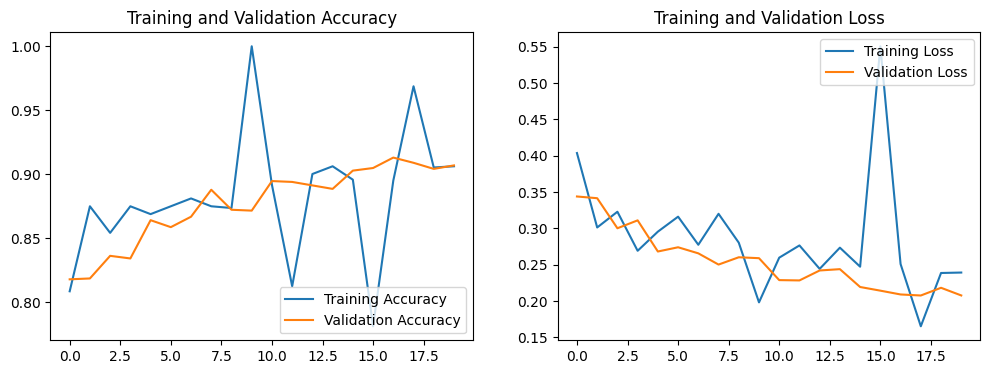

In [22]:
history, trained_model = train_efficientnet_from_folders(output_dir)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
!pip install tf2onnx keras2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.0 MB/s eta 0:00:00


In [27]:
import tensorflow as tf
import tf2onnx

h5_model = tf.keras.models.load_model("/content/split_dataset/best_model.h5")

onnx_model_path = "model.onnx"
spec = (tf.TensorSpec(h5_model.input_shape, tf.float32),)
onnx_model, _ = tf2onnx.convert.from_keras(h5_model, input_signature=spec, opset=13)

with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model converted and saved to {onnx_model_path}")


Model converted and saved to model.onnx
